
Parameters: Params(k=3.0, m=2.0, c=0.8)
Regime summary:
Coexistence equilibrium exists: m > c and k > N*.
Diagnostic: k > k_H = 1 + 2N* = 2.333333 so trJ(K3) > 0; K3 is unstable.
Typical behavior: trajectories approach a stable limit cycle (sustained oscillations).

Equilibria:
  K0 = [0. 0.]
  K1 = [3. 0.]
  N* = 0.6666666666666667
  K3 = [0.66666667 0.64814815]
  k_H = 2.333333, trJ(K3) = 8.888889e-02


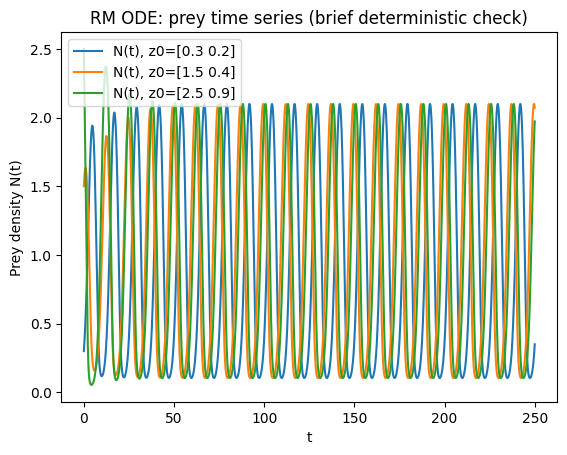

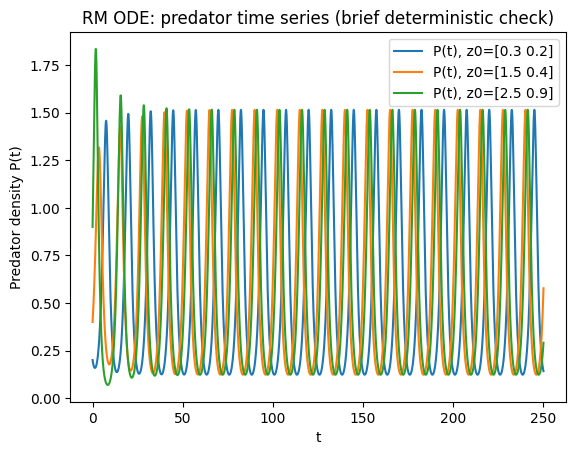

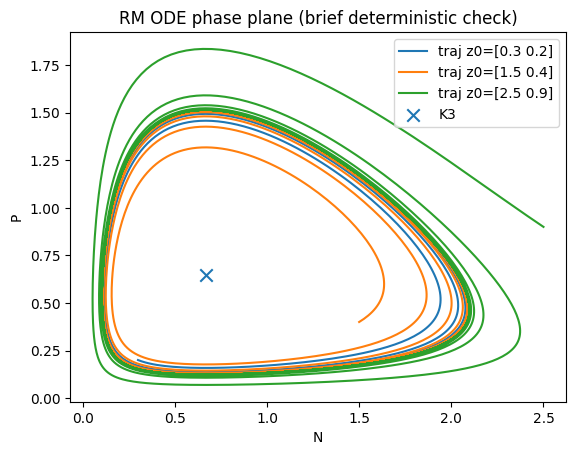


--- Extinction regime example (brief numeric check) ---
Parameters: Params(k=1.0, m=0.8, c=0.8)
Regime summary:
Deterministic predator extinction: m <= c.
Prediction: P(t) -> 0 and (for N0>0) N(t) -> k.
Terminal state at t=200.0: N=1.000000, P=0.000000 (expect P~0, N~k)


In [1]:
"""
Paper A — Section 8.1 Deterministic check (brief)
=================================================
This script provides a *minimal* deterministic check for the Rosenzweig–MacArthur (RM) ODE
that supports Paper A's narrative (parameter interpretation + boundedness intuition),
WITHOUT doing Hopf continuation or global planar dynamics proofs.

What it does:
1) Defines the RM ODE with Holling type II response.
2) Computes equilibria K0, K1, and (if it exists) coexistence equilibrium K3.
3) Reports deterministic extinction/coexistence thresholds:
   - Predator extinction if m <= c, or if m > c and k <= N* := c/(m-c) (including equality k=N*).
   - Coexistence equilibrium exists if m > c and k > N*.
4) (Optional but concise) Computes the Hopf threshold k_H = 1 + 2 N* and the Jacobian trace at K3:
   - If k < k_H, K3 is locally asymptotically stable (trace < 0, det > 0).
   - If k > k_H, K3 is unstable (trace > 0); trajectories typically approach a stable limit cycle.
   This is reported only as a *diagnostic* (no continuation; no proof).
5) Integrates a few trajectories and plots:
   - N(t) time series, P(t) time series
   - Phase plane with K3 marked (when it exists)

Dependencies:
- numpy
- scipy
- matplotlib
"""

from dataclasses import dataclass
from typing import Optional, Tuple, List
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


# -------------------------
# Model and utilities
# -------------------------
@dataclass(frozen=True)
class Params:
    k: float
    m: float
    c: float


def rm_rhs(t: float, z: np.ndarray, par: Params) -> np.ndarray:
    """RM ODE with Holling type II functional response."""
    N, P = z
    k, m, c = par.k, par.m, par.c
    dN = N * (1.0 - N / k) - (m * N * P) / (1.0 + N)
    dP = P * ((m * N) / (1.0 + N) - c)
    return np.array([dN, dP], dtype=float)


def compute_equilibria(par: Params) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray], Optional[float]]:
    """
    Return equilibria K0, K1, K3 (if exists), and N* (if m>c).
    K0 = (0,0), K1 = (k,0).
    K3 exists iff m>c and N*<k.
    """
    k, m, c = par.k, par.m, par.c
    K0 = np.array([0.0, 0.0])
    K1 = np.array([k, 0.0])

    if m <= c:
        return K0, K1, None, None

    N_star = c / (m - c)
    if N_star < k:
        P_star = (1.0 + N_star) / m * (1.0 - N_star / k)
        K3 = np.array([N_star, P_star], dtype=float)
        return K0, K1, K3, N_star

    # includes equality N_star == k (threshold): no positive equilibrium
    return K0, K1, None, N_star


def hopf_threshold(N_star: float) -> float:
    """Hopf threshold k_H = 1 + 2 N* (valid in coexistence regime)."""
    return 1.0 + 2.0 * N_star


def trace_at_K3(par: Params, N_star: float) -> float:
    """
    Trace of Jacobian at K3 simplifies to:
    tr J(K3) = (N*/(1+N*)) * (1 - (1+2N*)/k)
    """
    k = par.k
    return (N_star / (1.0 + N_star)) * (1.0 - (1.0 + 2.0 * N_star) / k)


def classify_regime(par: Params) -> str:
    """
    Paper A relevant deterministic classification:
    - Extinction region(s) for predator
    - Coexistence equilibrium existence
    Plus (brief diagnostic) local stability of K3 via k vs k_H when K3 exists.
    """
    k, m, c = par.k, par.m, par.c

    # Predator subcritical
    if m <= c:
        return (
            "Deterministic predator extinction: m <= c.\n"
            "Prediction: P(t) -> 0 and (for N0>0) N(t) -> k."
        )

    # m > c
    N_star = c / (m - c)

    if k < N_star:
        return (
            "Deterministic predator extinction: m > c but k < N* = c/(m-c).\n"
            "Prediction: P(t) -> 0 and (for N0>0) N(t) -> k."
        )

    if np.isclose(k, N_star):
        return (
            "Threshold equality: m > c and k = N*.\n"
            "Prediction (still): P(t) -> 0 and (for N0>0) N(t) -> k; no positive equilibrium."
        )

    # Coexistence equilibrium exists
    kH = hopf_threshold(N_star)
    tr = trace_at_K3(par, N_star)
    # det>0 in coexistence region; sign of trace determines local stability type
    if k < kH:
        return (
            "Coexistence equilibrium exists: m > c and k > N*.\n"
            f"Diagnostic: k < k_H = 1 + 2N* = {kH:.6f} so trJ(K3) < 0; K3 is locally asymptotically stable.\n"
            "Typical behavior: trajectories approach K3."
        )
    if np.isclose(k, kH):
        return (
            "Coexistence equilibrium exists: m > c and k > N*.\n"
            f"Diagnostic: k ≈ k_H = 1 + 2N* = {kH:.6f} so trJ(K3) ≈ 0; Hopf threshold (degenerate for numerics).\n"
            "Typical behavior: near-threshold long transients; small oscillations may appear."
        )
    return (
        "Coexistence equilibrium exists: m > c and k > N*.\n"
        f"Diagnostic: k > k_H = 1 + 2N* = {kH:.6f} so trJ(K3) > 0; K3 is unstable.\n"
        "Typical behavior: trajectories approach a stable limit cycle (sustained oscillations)."
    )


def simulate_ode(
    par: Params,
    z0: np.ndarray,
    T: float = 250.0,
    dt: float = 0.05,
    rtol: float = 1e-9,
    atol: float = 1e-12,
) -> Tuple[np.ndarray, np.ndarray]:
    """Integrate RM ODE and return (t_grid, z(t_grid))."""
    z0 = np.maximum(z0.astype(float), 0.0)  # enforce nonnegative start
    t_eval = np.arange(0.0, T + dt, dt)

    sol = solve_ivp(
        fun=lambda t, z: rm_rhs(t, z, par),
        t_span=(0.0, T),
        y0=z0,
        t_eval=t_eval,
        method="RK45",
        rtol=rtol,
        atol=atol,
        max_step=0.5,
    )
    if not sol.success:
        raise RuntimeError(f"ODE solver failed: {sol.message}")

    return sol.t, sol.y  # y shape = (2, len(t))


# -------------------------
# Plotting
# -------------------------
def plot_deterministic_check(
    par: Params,
    initials: List[np.ndarray],
    T: float = 250.0,
    dt: float = 0.05,
    show: bool = True,
    save_prefix: Optional[str] = None,
):
    """
    Produce 3 plots:
    1) Prey time series
    2) Predator time series
    3) Phase plane
    Optionally save figures as PNG with the given prefix.
    """
    # Regime + equilibria
    print("\nParameters:", par)
    print("Regime summary:\n" + classify_regime(par))

    K0, K1, K3, N_star = compute_equilibria(par)
    print("\nEquilibria:")
    print("  K0 =", K0)
    print("  K1 =", K1)
    if N_star is not None:
        print("  N* =", N_star)
    if K3 is not None:
        print("  K3 =", K3)
        kH = hopf_threshold(N_star)
        tr = trace_at_K3(par, N_star)
        print(f"  k_H = {kH:.6f}, trJ(K3) = {tr:.6e}")
    else:
        print("  K3 does not exist (no positive equilibrium).")

    # --- Prey time series ---
    fig1 = plt.figure()
    for z0 in initials:
        t, y = simulate_ode(par, z0, T=T, dt=dt)
        plt.plot(t, y[0, :], label=f"N(t), z0={np.array(z0)}")
    plt.xlabel("t")
    plt.ylabel("Prey density N(t)")
    plt.title("RM ODE: prey time series (brief deterministic check)")
    plt.legend()

    # --- Predator time series ---
    fig2 = plt.figure()
    for z0 in initials:
        t, y = simulate_ode(par, z0, T=T, dt=dt)
        plt.plot(t, y[1, :], label=f"P(t), z0={np.array(z0)}")
    plt.xlabel("t")
    plt.ylabel("Predator density P(t)")
    plt.title("RM ODE: predator time series (brief deterministic check)")
    plt.legend()

    # --- Phase plane ---
    fig3 = plt.figure()
    for z0 in initials:
        t, y = simulate_ode(par, z0, T=T, dt=dt)
        plt.plot(y[0, :], y[1, :], label=f"traj z0={np.array(z0)}")
    if K3 is not None:
        plt.scatter([K3[0]], [K3[1]], marker="x", s=80, label="K3")
    plt.xlabel("N")
    plt.ylabel("P")
    plt.title("RM ODE phase plane (brief deterministic check)")
    plt.legend()

    # Save if requested
    if save_prefix is not None:
        fig1.savefig(f"{save_prefix}_prey_timeseries.png", dpi=200, bbox_inches="tight")
        fig2.savefig(f"{save_prefix}_pred_timeseries.png", dpi=200, bbox_inches="tight")
        fig3.savefig(f"{save_prefix}_phase_plane.png", dpi=200, bbox_inches="tight")
        print(f"\nSaved figures with prefix: {save_prefix}_*.png")

    if show:
        plt.show()
    else:
        plt.close(fig1)
        plt.close(fig2)
        plt.close(fig3)


# -------------------------
# Main
# -------------------------
def main():
    # Example A (coexistence + oscillations): k > k_H
    par1 = Params(k=3.0, m=2.0, c=0.8)
    initials1 = [np.array([0.3, 0.2]), np.array([1.5, 0.4]), np.array([2.5, 0.9])]
    plot_deterministic_check(par1, initials1, T=250.0, dt=0.05, show=True, save_prefix=None)

    # Example B (subcritical extinction): m <= c
    par2 = Params(k=1.0, m=0.8, c=0.8)
    initials2 = [np.array([0.5, 0.6])]
    # For extinction case, just do a short run and print terminal values.
    print("\n--- Extinction regime example (brief numeric check) ---")
    print("Parameters:", par2)
    print("Regime summary:\n" + classify_regime(par2))
    t, y = simulate_ode(par2, initials2[0], T=200.0, dt=0.05)
    print(f"Terminal state at t={t[-1]:.1f}: N={y[0,-1]:.6f}, P={y[1,-1]:.6f} (expect P~0, N~k)")

    # Optional plots for extinction case (often not needed in Paper A)
    # plot_deterministic_check(par2, initials2, T=200.0, dt=0.05, show=True, save_prefix=None)


if __name__ == "__main__":
    main()

Single path (chol): tau_dt = 87.78
Single path (event): tau_dt = 51.31


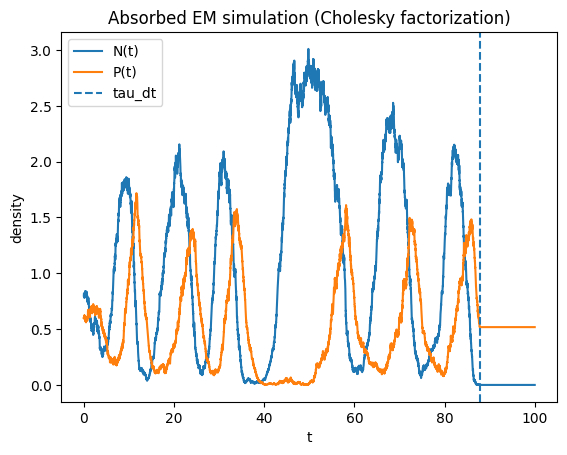

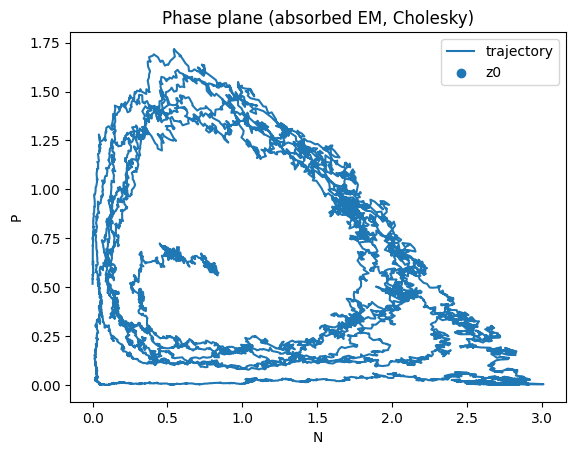

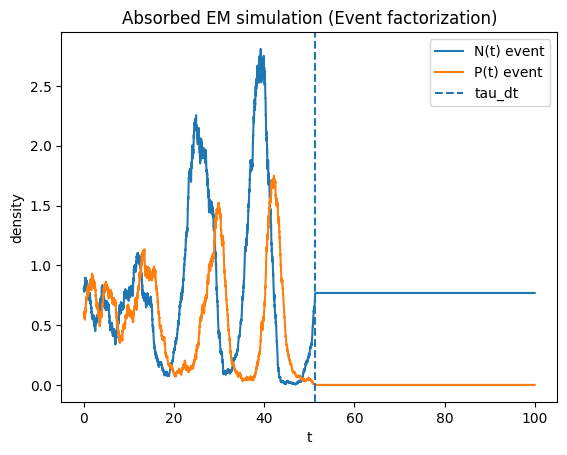

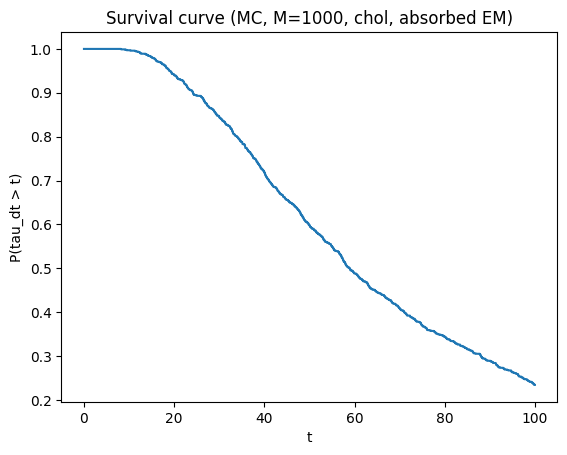

In [4]:
"""
Paper A — Section 8.2
Stochastic simulation of the absorbed mechanistic diffusion (Euler–Maruyama + clipping/freezing)

Implements:
- Drift mu(N,P) from eq. (mu_explicit_A)
- Event factorization L_ev (2x4) from eq. (Levent_explicit_A)
- Cholesky factor L_chol (2x2) from eq. (Cholesky_explicit_A)
- Euler–Maruyama scheme
- Absorption convention: clipping to 0 at first nonpositive coordinate, then freezing thereafter

Outputs:
- Example path plots (time series + phase plane)
- Optional Monte Carlo survival curve P(tau > t)

Dependencies: numpy, matplotlib
"""

from dataclasses import dataclass
from typing import Literal, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt


@dataclass(frozen=True)
class Params:
    k: float
    m: float
    c: float


def mu(z: np.ndarray, par: Params) -> np.ndarray:
    """Drift mu(N,P) = ( N - N^2/k - mNP/(1+N),  mNP/(1+N) - cP )."""
    N, P = z
    k, m, c = par.k, par.m, par.c
    denom = 1.0 + N
    return np.array(
        [
            N - (N * N) / k - (m * N * P) / denom,
            (m * N * P) / denom - c * P,
        ],
        dtype=float,
    )


def sigma_entries(z: np.ndarray, par: Params) -> Tuple[float, float, float]:
    """
    Return (Sigma11, Sigma12, Sigma22) for Sigma(N,P) in eq. (Sigma_explicit_A):
      Sigma11 = N + N^2/k + mNP/(1+N)
      Sigma12 = - mNP/(1+N)
      Sigma22 = cP + mNP/(1+N)
    """
    N, P = z
    k, m, c = par.k, par.m, par.c
    denom = 1.0 + N
    a = (m * N * P) / denom
    s11 = N + (N * N) / k + a
    s12 = -a
    s22 = c * P + a
    return float(s11), float(s12), float(s22)


def L_event(z: np.ndarray, par: Params) -> np.ndarray:
    """
    Event factorization L_ev (2x4) from eq. (Levent_explicit_A):
      columns correspond to B, C, D, E.
    """
    N, P = z
    k, m, c = par.k, par.m, par.c

    # Rates (density-level)
    lam_B = max(N, 0.0)
    lam_C = max((N * N) / k, 0.0)
    lam_D = max(c * P, 0.0)
    lam_E = max((m * N * P) / (1.0 + N), 0.0)

    L = np.zeros((2, 4), dtype=float)
    # Column B: sqrt(lam_B) * (1,0)
    L[:, 0] = [np.sqrt(lam_B), 0.0]
    # Column C: sqrt(lam_C) * (-1,0)
    L[:, 1] = [-np.sqrt(lam_C), 0.0]
    # Column D: sqrt(lam_D) * (0,-1)
    L[:, 2] = [0.0, -np.sqrt(lam_D)]
    # Column E: sqrt(lam_E) * (-1,1)
    s = np.sqrt(lam_E)
    L[:, 3] = [-s, s]
    return L


def L_cholesky(z: np.ndarray, par: Params) -> np.ndarray:
    """
    Cholesky factor L_chol (2x2) for Sigma on the interior U.
    For numerical stability, this handles small roundoff and clips the second diagonal term at 0.
    """
    s11, s12, s22 = sigma_entries(z, par)
    if s11 <= 0.0:
        # Degenerate case (on boundary); return zeros
        return np.zeros((2, 2), dtype=float)

    L = np.zeros((2, 2), dtype=float)
    L[0, 0] = np.sqrt(s11)
    L[1, 0] = s12 / L[0, 0]
    # Schur complement
    schur = s22 - (s12 * s12) / s11
    L[1, 1] = np.sqrt(max(schur, 0.0))
    return L


def em_absorbed_path(
    par: Params,
    z0: np.ndarray,
    rho: float = 0.1,
    dt: float = 1e-2,
    T: float = 50.0,
    factor: Literal["event", "chol"] = "chol",
    seed: Optional[int] = None,
) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Simulate one absorbed EM path.

    Absorption (clipping+freezing):
    - If after update N<=0 or P<=0: clip to 0 componentwise and mark absorbed.
    - Thereafter: keep state constant.

    Returns:
      t_grid: shape (n_steps+1,)
      Z: shape (n_steps+1, 2)
      tau_dt: discrete absorption time (np.inf if not absorbed by T)
    """
    rng = np.random.default_rng(seed)
    z0 = np.array(z0, dtype=float)
    if np.any(z0 <= 0.0):
        raise ValueError("Initial condition must be in U=(0,∞)^2 for this simulator.")

    n_steps = int(np.floor(T / dt))
    t = np.linspace(0.0, n_steps * dt, n_steps + 1)
    Z = np.zeros((n_steps + 1, 2), dtype=float)
    Z[0] = z0

    # driving dimension
    d = 4 if factor == "event" else 2
    sqrt_dt = np.sqrt(dt)

    absorbed = False
    tau_dt = np.inf

    for n in range(n_steps):
        if absorbed:
            Z[n + 1] = Z[n]  # freezing
            continue

        z = Z[n]
        drift = mu(z, par)

        if factor == "event":
            L = L_event(z, par)
        else:
            L = L_cholesky(z, par)

        dB = rng.standard_normal(d) * sqrt_dt
        # diffusion increment: (2xd) @ (d,)
        diff_inc = rho * (L @ dB)

        z_next = z + drift * dt + diff_inc

        # absorption test: if any coordinate <= 0, clip to 0 and freeze thereafter
        if (z_next[0] <= 0.0) or (z_next[1] <= 0.0):
            z_next = np.maximum(z_next, 0.0)  # clipping
            absorbed = True
            tau_dt = (n + 1) * dt

        Z[n + 1] = z_next

    return t, Z, tau_dt


def survival_curve_mc(
    par: Params,
    z0: np.ndarray,
    rho: float = 0.1,
    dt: float = 1e-2,
    T: float = 50.0,
    M: int = 2000,
    factor: Literal["event", "chol"] = "chol",
    seed: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Monte Carlo estimate of survival curve t -> P(tau_dt > t).

    Returns:
      t_grid: shape (n_steps+1,)
      surv:  shape (n_steps+1,)
    """
    rng = np.random.default_rng(seed)
    n_steps = int(np.floor(T / dt))
    t_grid = np.linspace(0.0, n_steps * dt, n_steps + 1)

    taus = np.empty(M, dtype=float)
    for i in range(M):
        _, _, tau_dt = em_absorbed_path(
            par,
            z0=z0,
            rho=rho,
            dt=dt,
            T=T,
            factor=factor,
            seed=int(rng.integers(0, 2**31 - 1)),
        )
        taus[i] = tau_dt

    surv = np.array([(taus > t).mean() for t in t_grid], dtype=float)
    return t_grid, surv


def main():
    # Example parameters (same as earlier deterministic check)
    par = Params(k=3.0, m=2.0, c=0.8)
    rho = 0.1         # Omega=100
    dt = 0.01
    T = 100.0
    z0 = np.array([0.8, 0.6])  # interior start

    # --- Single path (Cholesky) ---
    t, Z, tau_dt = em_absorbed_path(par, z0, rho=rho, dt=dt, T=T, factor="chol", seed=1)
    print(f"Single path (chol): tau_dt = {tau_dt}")

    plt.figure()
    plt.plot(t, Z[:, 0], label="N(t)")
    plt.plot(t, Z[:, 1], label="P(t)")
    plt.axvline(tau_dt, linestyle="--", label="tau_dt" if np.isfinite(tau_dt) else None)
    plt.xlabel("t")
    plt.ylabel("density")
    plt.title("Absorbed EM simulation (Cholesky factorization)")
    plt.legend()

    plt.figure()
    plt.plot(Z[:, 0], Z[:, 1], label="trajectory")
    plt.scatter([z0[0]], [z0[1]], marker="o", label="z0")
    plt.xlabel("N")
    plt.ylabel("P")
    plt.title("Phase plane (absorbed EM, Cholesky)")
    plt.legend()

    # --- Single path (Event factorization) ---
    t2, Z2, tau_dt2 = em_absorbed_path(par, z0, rho=rho, dt=dt, T=T, factor="event", seed=1)
    print(f"Single path (event): tau_dt = {tau_dt2}")

    plt.figure()
    plt.plot(t2, Z2[:, 0], label="N(t) event")
    plt.plot(t2, Z2[:, 1], label="P(t) event")
    plt.axvline(tau_dt2, linestyle="--", label="tau_dt" if np.isfinite(tau_dt2) else None)
    plt.xlabel("t")
    plt.ylabel("density")
    plt.title("Absorbed EM simulation (Event factorization)")
    plt.legend()

    # --- Monte Carlo survival curve (optional) ---
    M = 1000
    tS, surv = survival_curve_mc(par, z0, rho=rho, dt=dt, T=T, M=M, factor="chol", seed=123)
    plt.figure()
    plt.plot(tS, surv)
    plt.xlabel("t")
    plt.ylabel("P(tau_dt > t)")
    plt.title(f"Survival curve (MC, M={M}, chol, absorbed EM)")

    plt.show()


if __name__ == "__main__":
    main()

Running factorization-consistency Monte Carlo...
Params=Params(k=3.0, m=2.0, c=0.8), rho=0.1, dt=0.01, T=100.0, z0=[0.8, 0.6], M=2000
Event:  survivor_frac@T=100.0  = 0.244
Chol:   survivor_frac@T=100.0  = 0.245
Saved figure to: fig_sde_consistency.png


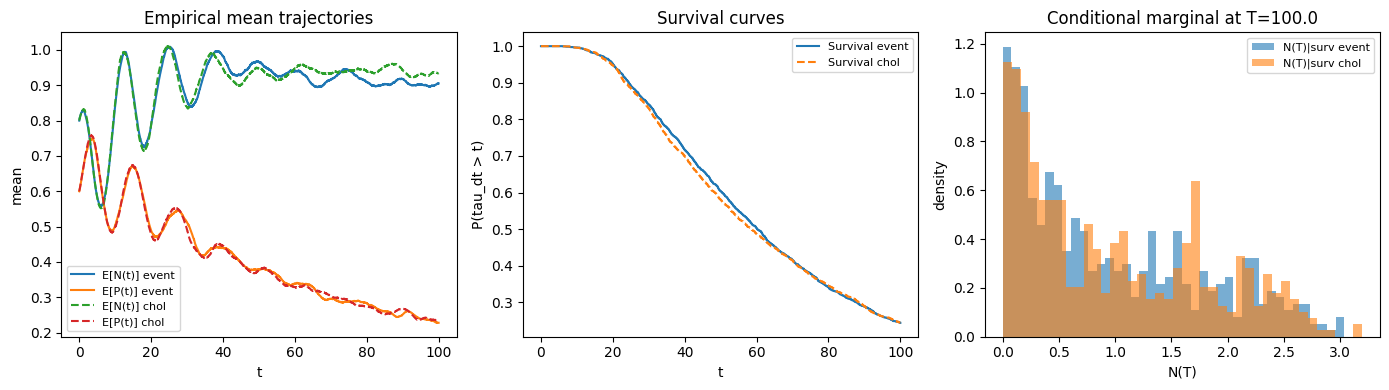

In [5]:
"""
Paper A — Section 8.3
Factorization consistency: event vs Cholesky (finite-sample diagnostics)

Goal:
Compare two equivalent factorizations of the same covariance Sigma(N,P):
  (i)  Event factorization  L_ev  (2x4)
  (ii) Cholesky factor      L_chol (2x2)
Both satisfy L L^T = Sigma on the interior U, hence define the same diffusion in continuous time.

We compare under absorbed Euler–Maruyama (EM) discretization (clipping + freezing at axes):
  (1) Unconditional mean trajectories E[N(t)], E[P(t)]
  (2) Survival curves  t -> P(tau_dt > t)
  (3) Conditional marginal of N(T) given survival (tau_dt > T)

Outputs:
- A 1x3 figure: mean trajectories (N,P), survival curves, conditional marginal histogram
- Optionally saves as fig_sde_consistency.png

Dependencies: numpy, matplotlib
"""

from dataclasses import dataclass
from typing import Literal, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt


@dataclass(frozen=True)
class Params:
    k: float
    m: float
    c: float


# --------------------------
# Model: mu, Sigma, factors
# --------------------------
def mu(z: np.ndarray, par: Params) -> np.ndarray:
    N, P = z
    k, m, c = par.k, par.m, par.c
    denom = 1.0 + N
    return np.array(
        [
            N - (N * N) / k - (m * N * P) / denom,
            (m * N * P) / denom - c * P,
        ],
        dtype=float,
    )


def sigma_entries(z: np.ndarray, par: Params) -> Tuple[float, float, float]:
    N, P = z
    k, m, c = par.k, par.m, par.c
    denom = 1.0 + N
    a = (m * N * P) / denom
    s11 = N + (N * N) / k + a
    s12 = -a
    s22 = c * P + a
    return float(s11), float(s12), float(s22)


def L_event(z: np.ndarray, par: Params) -> np.ndarray:
    """
    L_ev (2x4):
      columns correspond to events B, C, D, E.
    """
    N, P = z
    k, m, c = par.k, par.m, par.c

    lam_B = max(N, 0.0)
    lam_C = max((N * N) / k, 0.0)
    lam_D = max(c * P, 0.0)
    lam_E = max((m * N * P) / (1.0 + N), 0.0)

    L = np.zeros((2, 4), dtype=float)
    L[:, 0] = [np.sqrt(lam_B), 0.0]
    L[:, 1] = [-np.sqrt(lam_C), 0.0]
    L[:, 2] = [0.0, -np.sqrt(lam_D)]
    s = np.sqrt(lam_E)
    L[:, 3] = [-s, s]
    return L


def L_cholesky(z: np.ndarray, par: Params) -> np.ndarray:
    """Lower-triangular Cholesky factor (2x2) for Sigma on interior U; robustified for roundoff."""
    s11, s12, s22 = sigma_entries(z, par)
    if s11 <= 0.0:
        return np.zeros((2, 2), dtype=float)

    L = np.zeros((2, 2), dtype=float)
    L[0, 0] = np.sqrt(s11)
    L[1, 0] = s12 / L[0, 0]
    schur = s22 - (s12 * s12) / s11
    L[1, 1] = np.sqrt(max(schur, 0.0))
    return L


# --------------------------
# Absorbed EM simulator
# --------------------------
def em_absorbed_paths(
    par: Params,
    z0: np.ndarray,
    rho: float,
    dt: float,
    T: float,
    M: int,
    factor: Literal["event", "chol"] = "chol",
    seed: int = 0,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate M absorbed EM paths.

    Absorption (clipping+freezing):
      - If N or P becomes <=0 after an update: clip to 0 and mark absorbed.
      - After absorption: freeze at boundary point.

    Returns:
      t_grid: shape (n_steps+1,)
      Z: shape (M, n_steps+1, 2)
      tau_dt: shape (M,), absorption times (np.inf if not absorbed by T)
    """
    rng = np.random.default_rng(seed)
    z0 = np.array(z0, dtype=float)
    if np.any(z0 <= 0.0):
        raise ValueError("z0 must be in U=(0,∞)^2")

    n_steps = int(np.floor(T / dt))
    t_grid = np.linspace(0.0, n_steps * dt, n_steps + 1)

    Z = np.zeros((M, n_steps + 1, 2), dtype=float)
    Z[:, 0, :] = z0[None, :]
    tau_dt = np.full(M, np.inf, dtype=float)

    d = 4 if factor == "event" else 2
    sqrt_dt = np.sqrt(dt)

    # Pre-generate Gaussian increments for speed: (M, n_steps, d)
    dB = rng.standard_normal((M, n_steps, d)) * sqrt_dt

    absorbed = np.zeros(M, dtype=bool)

    for n in range(n_steps):
        # update only non-absorbed
        idx = np.where(~absorbed)[0]
        if idx.size == 0:
            # all absorbed; just freeze forward
            Z[:, n + 1, :] = Z[:, n, :]
            continue

        # freeze absorbed ones
        Z[absorbed, n + 1, :] = Z[absorbed, n, :]

        # update active ones
        for i in idx:
            z = Z[i, n, :]
            drift = mu(z, par)

            if factor == "event":
                L = L_event(z, par)
            else:
                L = L_cholesky(z, par)

            z_next = z + drift * dt + rho * (L @ dB[i, n, :])

            # absorption trigger
            if (z_next[0] <= 0.0) or (z_next[1] <= 0.0):
                z_next = np.maximum(z_next, 0.0)  # clipping
                absorbed[i] = True
                tau_dt[i] = (n + 1) * dt

            Z[i, n + 1, :] = z_next

    return t_grid, Z, tau_dt


# --------------------------
# Diagnostics + plotting
# --------------------------
def compute_diagnostics(t: np.ndarray, Z: np.ndarray, tau_dt: np.ndarray) -> dict:
    """
    Given trajectories Z (M, T, 2) and tau_dt (M,), compute:
      - mean_N(t), mean_P(t)
      - survival(t) = P(tau_dt > t)
      - conditional sample of N(T) given survival
    """
    mean_N = Z[:, :, 0].mean(axis=0)
    mean_P = Z[:, :, 1].mean(axis=0)
    survival = np.array([(tau_dt > tt).mean() for tt in t], dtype=float)

    T_final = t[-1]
    survivors = tau_dt > T_final
    N_T_surv = Z[survivors, -1, 0] if np.any(survivors) else np.array([], dtype=float)

    return {
        "mean_N": mean_N,
        "mean_P": mean_P,
        "survival": survival,
        "N_T_surv": N_T_surv,
        "survivor_frac": float(survivors.mean()),
        "T_final": float(T_final),
    }


def plot_consistency_figure(
    t: np.ndarray,
    diag_ev: dict,
    diag_ch: dict,
    bins: int = 40,
    savepath: Optional[str] = "fig_sde_consistency.png",
    show: bool = True,
):
    """
    Create a 1x3 figure:
      Left: mean trajectories (N and P) for both methods
      Center: survival curves
      Right: conditional marginal of N(T) given survival
    """
    fig = plt.figure(figsize=(14, 4))

    # (1) mean trajectories
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.plot(t, diag_ev["mean_N"], label="E[N(t)] event")
    ax1.plot(t, diag_ev["mean_P"], label="E[P(t)] event")
    ax1.plot(t, diag_ch["mean_N"], linestyle="--", label="E[N(t)] chol")
    ax1.plot(t, diag_ch["mean_P"], linestyle="--", label="E[P(t)] chol")
    ax1.set_xlabel("t")
    ax1.set_ylabel("mean")
    ax1.set_title("Empirical mean trajectories")
    ax1.legend(fontsize=8)

    # (2) survival curves
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.plot(t, diag_ev["survival"], label="Survival event")
    ax2.plot(t, diag_ch["survival"], linestyle="--", label="Survival chol")
    ax2.set_xlabel("t")
    ax2.set_ylabel("P(tau_dt > t)")
    ax2.set_title("Survival curves")
    ax2.legend(fontsize=8)

    # (3) conditional marginal N(T) | survival
    ax3 = fig.add_subplot(1, 3, 3)
    if diag_ev["N_T_surv"].size > 0:
        ax3.hist(diag_ev["N_T_surv"], bins=bins, density=True, alpha=0.6, label="N(T)|surv event")
    if diag_ch["N_T_surv"].size > 0:
        ax3.hist(diag_ch["N_T_surv"], bins=bins, density=True, alpha=0.6, label="N(T)|surv chol")
    ax3.set_xlabel("N(T)")
    ax3.set_ylabel("density")
    ax3.set_title(f"Conditional marginal at T={diag_ev['T_final']:.1f}")
    ax3.legend(fontsize=8)

    fig.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")
        print(f"Saved figure to: {savepath}")

    if show:
        plt.show()
    else:
        plt.close(fig)


def main():
    # Parameters consistent with Paper A numerics narrative
    par = Params(k=3.0, m=2.0, c=0.8)
    rho = 0.1          # Omega=100
    dt = 1e-2
    T = 100.0
    z0 = np.array([0.8, 0.6])
    M = 2000

    print("Running factorization-consistency Monte Carlo...")
    print(f"Params={par}, rho={rho}, dt={dt}, T={T}, z0={z0.tolist()}, M={M}")

    # Event factorization
    t, Z_ev, tau_ev = em_absorbed_paths(par, z0, rho, dt, T, M, factor="event", seed=123)
    diag_ev = compute_diagnostics(t, Z_ev, tau_ev)
    print(f"Event:  survivor_frac@T={diag_ev['T_final']:.1f}  = {diag_ev['survivor_frac']:.3f}")

    # Cholesky factorization
    t, Z_ch, tau_ch = em_absorbed_paths(par, z0, rho, dt, T, M, factor="chol", seed=456)
    diag_ch = compute_diagnostics(t, Z_ch, tau_ch)
    print(f"Chol:   survivor_frac@T={diag_ch['T_final']:.1f}  = {diag_ch['survivor_frac']:.3f}")

    # Plot comparison
    plot_consistency_figure(
        t=t,
        diag_ev=diag_ev,
        diag_ch=diag_ch,
        bins=40,
        savepath="fig_sde_consistency.png",
        show=True,
    )


if __name__ == "__main__":
    main()

Running covariance-role comparison (full vs diagonal surrogate)...
Params=Params(k=3.0, m=2.0, c=0.8), rho=0.1, dt=0.01, T=100.0, z0=[0.8, 0.6], M=2000
Full Σ: survivor_frac@T=100.0 = 0.255
Diag Σ: survivor_frac@T=100.0 = 0.247
Saved figure to: fig_covariance_role.png


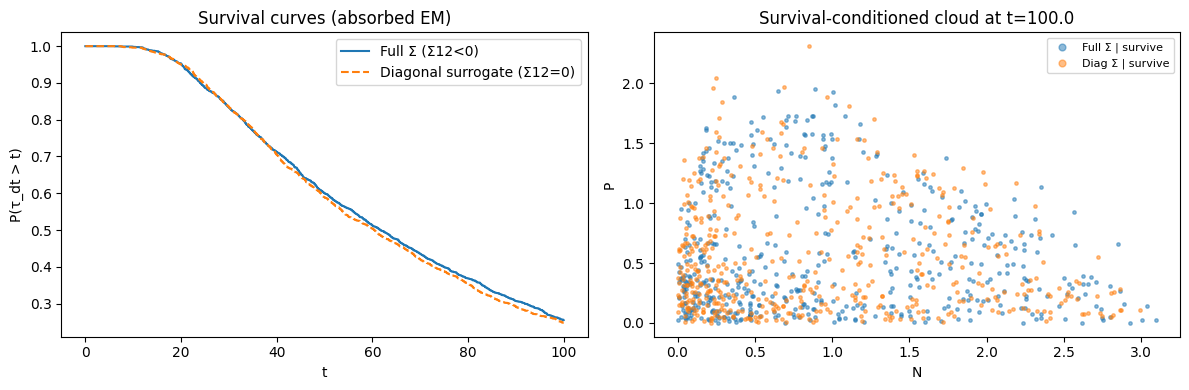

In [6]:
"""
Paper A — Section 8.4
Role of covariance: full Sigma vs diagonal surrogate (matched marginal variances)

We compare:
  FULL model:    dZ = mu(Z) dt + rho * L_chol(Z) dB,  where L_chol L_chol^T = Sigma (with Sigma12<0)
  DIAG surrogate dZ = mu(Z) dt + rho * L_diag(Z) dB,  where L_diag L_diag^T = Sigma_diag = diag(Sigma11,Sigma22)

Both use the same drift mu. The diagonal surrogate removes instantaneous correlation while preserving pointwise
marginal variances.

Numerics:
- Absorbed Euler–Maruyama with clipping+freezing at axes
- Diagnostics:
  (i) Survival curves t -> P(tau_dt > t)
  (ii) Snapshot of survival-conditioned particle cloud at time T_snap (phase plane)
- Saves a figure fig_covariance_role.png with two panels (survival curves, snapshot cloud)

Dependencies: numpy, matplotlib
"""

from dataclasses import dataclass
from typing import Tuple, Optional, Literal
import numpy as np
import matplotlib.pyplot as plt


@dataclass(frozen=True)
class Params:
    k: float
    m: float
    c: float


# --------------------------
# Drift and covariance
# --------------------------
def mu(z: np.ndarray, par: Params) -> np.ndarray:
    """Drift mu(N,P)."""
    N, P = z
    k, m, c = par.k, par.m, par.c
    denom = 1.0 + N
    return np.array(
        [
            N - (N * N) / k - (m * N * P) / denom,
            (m * N * P) / denom - c * P,
        ],
        dtype=float,
    )


def sigma_entries(z: np.ndarray, par: Params) -> Tuple[float, float, float]:
    """
    Sigma entries (Sigma11, Sigma12, Sigma22) for mechanistic covariance:
      Sigma11 = N + N^2/k + mNP/(1+N)
      Sigma12 = - mNP/(1+N)
      Sigma22 = cP + mNP/(1+N)
    """
    N, P = z
    k, m, c = par.k, par.m, par.c
    denom = 1.0 + N
    a = (m * N * P) / denom
    s11 = N + (N * N) / k + a
    s12 = -a
    s22 = c * P + a
    return float(s11), float(s12), float(s22)


def L_cholesky_full(z: np.ndarray, par: Params) -> np.ndarray:
    """Lower-triangular Cholesky factor of full Sigma on interior U (robustified)."""
    s11, s12, s22 = sigma_entries(z, par)
    if s11 <= 0.0:
        return np.zeros((2, 2), dtype=float)

    L = np.zeros((2, 2), dtype=float)
    L[0, 0] = np.sqrt(s11)
    L[1, 0] = s12 / L[0, 0]
    schur = s22 - (s12 * s12) / s11
    L[1, 1] = np.sqrt(max(schur, 0.0))
    return L


def L_diag_surrogate(z: np.ndarray, par: Params) -> np.ndarray:
    """Diagonal square-root factor of Sigma_diag = diag(Sigma11,Sigma22)."""
    s11, _, s22 = sigma_entries(z, par)
    L = np.zeros((2, 2), dtype=float)
    L[0, 0] = np.sqrt(max(s11, 0.0))
    L[1, 1] = np.sqrt(max(s22, 0.0))
    return L


# --------------------------
# Absorbed EM simulation
# --------------------------
def em_absorbed_paths(
    par: Params,
    z0: np.ndarray,
    rho: float,
    dt: float,
    T: float,
    M: int,
    model: Literal["full", "diag"] = "full",
    seed: int = 0,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate M absorbed EM paths for either:
      model="full": Sigma with negative cross-covariance (Cholesky factor)
      model="diag": diagonal surrogate (matched variances)

    Absorption: clipping + freezing at first time N<=0 or P<=0.

    Returns:
      t_grid: (n_steps+1,)
      Z:      (M, n_steps+1, 2)
      tau_dt: (M,) absorption times (np.inf if not absorbed by T)
    """
    rng = np.random.default_rng(seed)
    z0 = np.array(z0, dtype=float)
    if np.any(z0 <= 0.0):
        raise ValueError("z0 must be in U=(0,∞)^2")

    n_steps = int(np.floor(T / dt))
    t_grid = np.linspace(0.0, n_steps * dt, n_steps + 1)

    Z = np.zeros((M, n_steps + 1, 2), dtype=float)
    Z[:, 0, :] = z0[None, :]
    tau_dt = np.full(M, np.inf, dtype=float)
    absorbed = np.zeros(M, dtype=bool)

    sqrt_dt = np.sqrt(dt)
    # Use 2D Brownian increments for both full and diag (both are 2x2 factors here)
    dB = rng.standard_normal((M, n_steps, 2)) * sqrt_dt

    for n in range(n_steps):
        # freeze absorbed
        Z[absorbed, n + 1, :] = Z[absorbed, n, :]

        idx = np.where(~absorbed)[0]
        if idx.size == 0:
            continue

        for i in idx:
            z = Z[i, n, :]
            drift = mu(z, par)
            if model == "full":
                L = L_cholesky_full(z, par)
            else:
                L = L_diag_surrogate(z, par)

            z_next = z + drift * dt + rho * (L @ dB[i, n, :])

            if (z_next[0] <= 0.0) or (z_next[1] <= 0.0):
                z_next = np.maximum(z_next, 0.0)
                absorbed[i] = True
                tau_dt[i] = (n + 1) * dt

            Z[i, n + 1, :] = z_next

    return t_grid, Z, tau_dt


def survival_curve(t_grid: np.ndarray, tau_dt: np.ndarray) -> np.ndarray:
    """Compute survival curve S(t)=P(tau_dt > t) on grid."""
    return np.array([(tau_dt > t).mean() for t in t_grid], dtype=float)


# --------------------------
# Plot: survival + snapshot cloud
# --------------------------
def plot_covariance_role(
    t_grid: np.ndarray,
    surv_full: np.ndarray,
    surv_diag: np.ndarray,
    Z_full: np.ndarray,
    tau_full: np.ndarray,
    Z_diag: np.ndarray,
    tau_diag: np.ndarray,
    T_snap: float,
    savepath: Optional[str] = "fig_covariance_role.png",
    show: bool = True,
):
    """
    Two-panel figure:
      Left: survival curves (full vs diag)
      Right: survival-conditioned particle cloud at time T_snap (scatter in phase plane)
    """
    # pick snapshot index
    idx_snap = int(np.argmin(np.abs(t_grid - T_snap)))
    T_snap_actual = float(t_grid[idx_snap])

    # survivors at snapshot time
    surv_mask_full = tau_full > T_snap_actual
    surv_mask_diag = tau_diag > T_snap_actual

    cloud_full = Z_full[surv_mask_full, idx_snap, :]
    cloud_diag = Z_diag[surv_mask_diag, idx_snap, :]

    fig = plt.figure(figsize=(12, 4))

    # Survival curves
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(t_grid, surv_full, label="Full Σ (Σ12<0)")
    ax1.plot(t_grid, surv_diag, linestyle="--", label="Diagonal surrogate (Σ12=0)")
    ax1.set_xlabel("t")
    ax1.set_ylabel("P(τ_dt > t)")
    ax1.set_title("Survival curves (absorbed EM)")
    ax1.legend()

    # Snapshot cloud
    ax2 = fig.add_subplot(1, 2, 2)
    if cloud_full.size > 0:
        ax2.scatter(cloud_full[:, 0], cloud_full[:, 1], s=6, alpha=0.5, label="Full Σ | survive")
    if cloud_diag.size > 0:
        ax2.scatter(cloud_diag[:, 0], cloud_diag[:, 1], s=6, alpha=0.5, label="Diag Σ | survive")
    ax2.set_xlabel("N")
    ax2.set_ylabel("P")
    ax2.set_title(f"Survival-conditioned cloud at t={T_snap_actual:.1f}")
    ax2.legend(markerscale=2, fontsize=8)

    fig.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")
        print(f"Saved figure to: {savepath}")

    if show:
        plt.show()
    else:
        plt.close(fig)


def main():
    # Tested regime (as in Paper A text)
    par = Params(k=3.0, m=2.0, c=0.8)
    rho = 0.1     # Omega=100
    dt = 1e-2
    T = 100.0
    T_snap = 100.0
    z0 = np.array([0.8, 0.6])
    M = 2000

    print("Running covariance-role comparison (full vs diagonal surrogate)...")
    print(f"Params={par}, rho={rho}, dt={dt}, T={T}, z0={z0.tolist()}, M={M}")

    # Full covariance
    t_grid, Z_full, tau_full = em_absorbed_paths(
        par, z0, rho=rho, dt=dt, T=T, M=M, model="full", seed=111
    )
    surv_full = survival_curve(t_grid, tau_full)
    print(f"Full Σ: survivor_frac@T={t_grid[-1]:.1f} = {(tau_full > t_grid[-1]).mean():.3f}")

    # Diagonal surrogate
    t_grid2, Z_diag, tau_diag = em_absorbed_paths(
        par, z0, rho=rho, dt=dt, T=T, M=M, model="diag", seed=222
    )
    surv_diag = survival_curve(t_grid2, tau_diag)
    print(f"Diag Σ: survivor_frac@T={t_grid2[-1]:.1f} = {(tau_diag > t_grid2[-1]).mean():.3f}")

    # Plot
    plot_covariance_role(
        t_grid=t_grid,
        surv_full=surv_full,
        surv_diag=surv_diag,
        Z_full=Z_full,
        tau_full=tau_full,
        Z_diag=Z_diag,
        tau_diag=tau_diag,
        T_snap=T_snap,
        savepath="fig_covariance_role.png",
        show=True,
    )


if __name__ == "__main__":
    main()